In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [10]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

## Loading the data
Importing the data - JSON file

In [17]:
# data loading
# json 파일을 line 별로 읽어오게 됨
data = pd.read_json('./data/combined.json', lines=True)

In [18]:
data.head(8)

,id,title,contents,date,topics,components
0,None,Convicted Bomb Plotter Sentenced to 30 Years,"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01T00:00:00-04:00,[],[National Security Division (NSD)]
1,12-919,$1 Million in Restitution Payments Announced t...,WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25T00:00:00-04:00,[],[Environment and Natural Resources Division]
2,11-1002,$1 Million Settlement Reached for Natural Reso...,BOSTON– A $1-million settlement has been...,2011-08-03T00:00:00-04:00,[],[Environment and Natural Resources Division]
3,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08T00:00:00-05:00,[],[Environment and Natural Resources Division]
4,18-898,$100 Million Settlement Will Speed Cleanup Wor...,"The U.S. Department of Justice, the U.S. Envir...",2018-07-09T00:00:00-04:00,[Environment],[Environment and Natural Resources Division]
5,None,105 Individuals Indicted for Violating the RIC...,A nine count federal indictment was unsealed t...,2015-07-22T00:00:00-04:00,[],[USAO - Puerto Rico]
6,14-032,12th Former Officer at Roxbury Correctional In...,"Michael Morgan, formerly an officer at Roxbury...",2014-01-10T00:00:00-05:00,[],"[Civil Rights Division, Civil Rights - Crimina..."
7,14-1412,14 Indicted in Connection with New England Com...,A 131-count criminal indictment was unsealed t...,2014-12-17T00:00:00-05:00,[Consumer Protection],[Civil Division]


In [19]:
data.shape

(13087, 6)

In [6]:
print("보도내용 확인하기 - 일부만 발췌","\n")
print(data["contents"][4][:2084], end="") # end = "" => 한칸 밑으로 없이 이후 print 내용을 이어서 붙임
print("................","\n")
print("이하 내용 생략")

보도내용 확인하기 - 일부만 발췌 

The U.S. Department of Justice, the U.S. Environmental Protection Agency (EPA), and the Rhode Island Department of Environmental Management (RIDEM) announced today that two subsidiaries of Stanley Black & Decker Inc.—Emhart Industries Inc. and Black & Decker Inc.—have agreed to clean up dioxin contaminated sediment and soil at the Centredale Manor Restoration Project Superfund Site in North Providence and Johnston, Rhode Island.  “We are pleased to reach a resolution through collaborative work with the responsible parties, EPA, and other stakeholders,” said Acting Assistant Attorney General Jeffrey H. Wood for the Justice Department's Environment and Natural Resources Division . “Today’s settlement ends protracted litigation and allows for important work to get underway to restore a healthy environment for citizens living in and around the Centredale Manor Site and the Woonasquatucket River.” “This settlement demonstrates the tremendous progress we are achieving wo

In [21]:
print("data 의 크기: {}".format(data.shape))

data 의 크기: (13087, 6)


In [24]:
print("다양한 topics 들 확인해보기")
np.unique(data["topics"])[[10, 20, 100, 200]]

다양한 topics 들 확인해보기


array([list(['Antitrust', 'Financial Fraud', 'Securities, Commodities, & Investment Fraud', 'StopFraud']),
       list(['Asset Forfeiture', 'Cyber Crime']),
       list(['Drug Trafficking', 'Indian Country Law and Justice']),
       list(['Mortgage Fraud', 'Tax'])], dtype=object)

## 군집 분석에 사용 될 keywords 추출

TfidfVectorizer를 이용해서 내부적으로 TF-IDF 를 구한다.  
이후 클러스터링에 사용할 수있는 고유한 단어를 추출해주는 결과값을 가지게된다.

##### 간단한 예시를 통해 TfidfVectorizer 와 그에 대한 결과값을 알아보자

     1- min_df : 고유한 단어에 포함되기 위한 최소 등장 빈도
     2- max_df : 고유한 단어에 포함되기 위한 최대 빈도 (실수로 되어있는 경우 % 수치를 의미)
     3- stop_words : 빈번하게 나오는 단어는 자동으로 count 하지 않음

##### 함수 설명

     1- fit_transform(text_data) + todense : text_data 내의 단어의 TF-IDF 가 구해졌으면, matrix 형태로 출력 (todense 이용)
     2- get_feature_names() : TF-IDF 를 구해서 추출된 고유한 단어를 확인


In [25]:
# example sentence

corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

In [26]:
# fit_transform(text_data): text_data 내의 단어의 TF-IDF 를 계산
# get_feature_names() : TF-IDF 를 구해서 추출된 고유한 단어를 확인

vectorizer_ex1 = TfidfVectorizer()
X1 = vectorizer_ex1.fit_transform(corpus)

print(vectorizer_ex1.get_feature_names())
print(X1)

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
  (0, 1)	0.46979138557992045
  (0, 2)	0.5802858236844359
  (0, 6)	0.38408524091481483
  (0, 3)	0.38408524091481483
  (0, 8)	0.38408524091481483
  (1, 5)	0.5386476208856763
  (1, 1)	0.6876235979836938
  (1, 6)	0.281088674033753
  (1, 3)	0.281088674033753
  (1, 8)	0.281088674033753
  (2, 4)	0.511848512707169
  (2, 7)	0.511848512707169
  (2, 0)	0.511848512707169
  (2, 6)	0.267103787642168
  (2, 3)	0.267103787642168
  (2, 8)	0.267103787642168
  (3, 1)	0.46979138557992045
  (3, 2)	0.5802858236844359
  (3, 6)	0.38408524091481483
  (3, 3)	0.38408524091481483
  (3, 8)	0.38408524091481483


In [27]:
# matrix 형태로 출력
X1_dense = X1.todense()
print(X1_dense)

[[0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]
 [0.         0.6876236  0.         0.28108867 0.         0.53864762
  0.28108867 0.         0.28108867]
 [0.51184851 0.         0.         0.26710379 0.51184851 0.
  0.26710379 0.51184851 0.26710379]
 [0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]]


Feature name 순으로 (['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']) <br>
TF-IDF 를 출력하였다.<br>

첫번째 문장은 'This is the first document.' 이고<br>
TF-IDF 값이 0이 아닌 Feature 만을 살펴본다면  'document', 'first, 'is', 'the', 'this' 가 있다.<br>
각각의 TF-IDF 는 0.469, 0.580, 0.384, 0.384, 0.384 이다.

##### TfidfVectorizer 의 parameter 를 변형시켜보자

parameter 값에 따라 결과값이 달라짐 또한 확인 할 수 있다.

In [28]:
vectorizer_ex2 = TfidfVectorizer(min_df = 2, max_df = 0.95)
X2 = vectorizer_ex2.fit_transform(corpus)

print(X2.shape)
print(vectorizer_ex2.get_feature_names())
print(X2)

(4, 2)
['document', 'first']
  (0, 0)	0.6292275146695526
  (0, 1)	0.7772211620785797
  (1, 0)	1.0
  (3, 0)	0.6292275146695526
  (3, 1)	0.7772211620785797


In [13]:
# matrix 형태로 출력
print(X2.todense().shape)
X2.todense()

(4, 2)


matrix([[0.62922751, 0.77722116],
        [1.        , 0.        ],
        [0.        , 0.        ],
        [0.62922751, 0.77722116]])

### 본래 데이터에 적용시켜보자

In [33]:
vectorizer  = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english')
text =  vectorizer.fit_transform(data.contents) # data.contents => 본문 내용이 수록되어있음

In [35]:
print("추출된 단어의 개수: ", len(vectorizer.get_feature_names()))
print("=============================================================")
print(vectorizer.get_feature_names())

추출된 단어의 개수:  21551
['00', '000', '001', '003', '005', '006', '007', '009', '01', '011', '015', '016', '017', '018', '019', '02', '020', '021', '024', '025', '026', '028', '03', '030', '0301', '031', '034', '036', '038', '0383', '0390', '04', '040', '043', '046', '049', '05', '050', '051', '052', '054', '055', '056', '057', '06', '060', '064', '065', '066', '067', '069', '07', '074', '075', '076', '079', '08', '080', '083', '088', '089', '09', '090', '092', '094', '097', '098', '099', '10', '100', '1000', '1001', '10064', '100th', '101', '1010', '102', '1028a', '103', '104', '1040', '105', '106', '107', '1070', '108', '109', '1099', '10th', '11', '110', '1100', '111', '112', '113', '114', '115', '116', '117', '118', '119', '11th', '12', '120', '1200', '121', '122', '123', '124', '125', '126', '127', '128', '129', '12th', '13', '130', '1300', '131', '132', '133', '13382', '134', '135', '136', '137', '1373', '138', '139', '13th', '14', '140', '1400', '141', '1412', '14141', '142', '143', 

## Cluster 의 갯수 구하기
Elbow point 를 이용해 cluster 를 몇개로 설정하면 좋을지 알아보자  
Error 값이 천천히 낮아지는 구간을 스스로 판단해서 설정해보자

In [36]:
def number_of_clusters(input_data):
    # error 값을 담는 빈 list 생성
    error_value = []
    
    for i in range(1,20,2):
        # 그냥 1000개씩 끊어서 분석하는 것.
        k_means = MiniBatchKMeans(n_clusters=i, batch_size=1000, random_state=20)
        k_means.fit(input_data)
        
        # list 에 error 값을 하나씩 담는다
        '''
        intertia ????  
        중심점에서 군집의 데이타간의 거리를 합산한것이으로 군집의 응집도를 나타내는 값
        이 값이 작을 수록 응집도가 높게 군집화가 잘되었다고 평가할 수 있다.
        '''
        error_value.append(k_means.inertia_)
        
    return error_value           

In [37]:
text

<13087x21551 sparse matrix of type '<class 'numpy.float64'>'
	with 2544870 stored elements in Compressed Sparse Row format>

In [38]:
# TF-IDF Score 를 구한 data 를 이용해 error 값 산출
errors = number_of_clusters(text)
errors

[12565.743617911665,
 12202.341712416195,
 11918.385932311467,
 11778.431540273703,
 11701.57251893391,
 11615.334297739431,
 11498.097364785384,
 11438.344635772435,
 11389.648569254077,
 11335.275031702078]

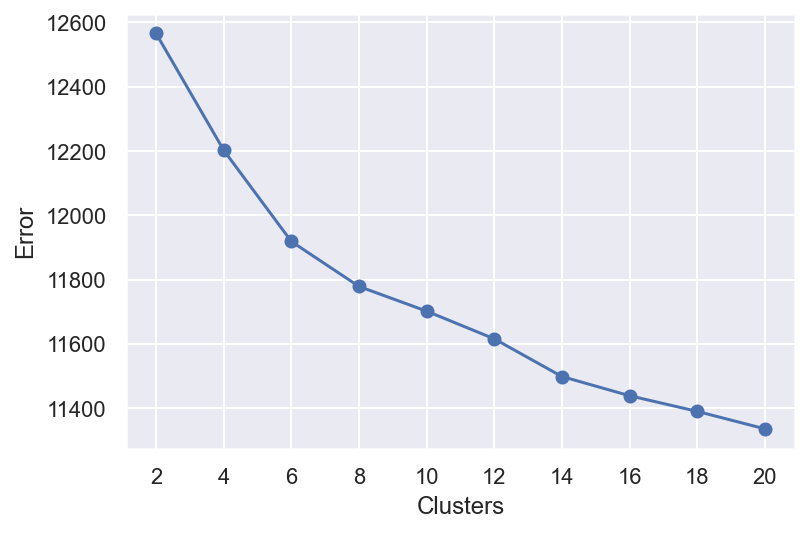

In [39]:
plt.plot(range(2,21,2), errors, marker = 'o')
plt.xlabel("Clusters")
plt.xticks(np.arange(2, 21, step=2))
plt.ylabel("Error")
plt.show()

여기서 error는 중심과의 거리의 square sum.Cluster가 많아지면 에러는 줄어든다. 다만, 급격히 떨어지는 부분이 있다. elbow point를 보통 클러스터 삼는다. 

총 **14개** 의 cluster 를 이용해서 군집분석을 하기로 결정하였다.

K-means 를 사용해서 text data 를 군집화 시킨다  
Cluster 의 개수는 14개로 설정한다

In [40]:
number_of_clusters = 14
cluster_labels = MiniBatchKMeans(n_clusters=number_of_clusters, batch_size=1000, random_state=20).fit_predict(text)

## Plotting Clusters
클러스터링이 제대로 이루어졌는지 확인하기 위해 PCA 를 이용하여 2차원으로 차원을 축소한 후 그래프를 그려보도록 한다

     1- 13,087 개의 sample 중 무작위로 3000 뽑기 (전체 data 를 이용하면 시간이 너무 오래걸린다)
     2- 무작위로 뽑은 3000개로 PCA 를 수행, components = 2 로 설정
     3- 3000개의 PCA 를 수행한 샘플중 plot 을 그리기 위해 무작위로 300개를 다시 뽑는다
     4- 300개를 뽑은 샘플의 cluster 또한 가지고 와야 하므로 label_subset 변수에 넣어준다
     5- plt.cm.hsv 함수를 이용하여 색깔별로 나누어 준 후 scatter 그래프를 그려준다

In [42]:
cluster_labels

array([11,  3,  3, ..., 11, 11, 11], dtype=int32)

In [45]:
def plot_pca(data, cluster_labels):
    
    # 13087 개의 sample 중 랜덤하게 3000개를 뽑는 코드
    
    # 1. index 섞어주기
    # data.shape[0] = 샘플의 갯수 (13087 개의 data 이므로 13087 개)    
    # pca_idx = 3,000 / 즉, PCA 를 수행할 3000개의 샘플만 랜덤하게 뽑아준다
    pca_idx = np.random.choice(range(data.shape[0]), size=3000, replace=False) # replace => True 한번 선택한 데이터를 다시 선택 가능
    
    # 2. PCA 수행
    # 2차원 평면에 그릴 것이므로 components 는 2로 설정
    # 랜덤하게 뽑은 size (3000개) 만 이용해서 PCA를 수행
    # 3000개로 PCA 수행, component 는 2
    random_data = data[pca_idx,:]
    pca = PCA(n_components=2)
    pca_2d = pca.fit_transform(random_data.todense()) # data[pca_idx,:] = randome 하게 뽑은 3000개
    
    # pca 수행한 것 중에서 300개를 랜덤하게 추출 (3000개 중에서 300개를 또 추출한다고 생각)
    idx = np.random.choice(range(pca_2d.shape[0]), size=300, replace=False)
                           
    # plotting 할 data 에 해당하는 clustering label 을 가져온다
    label_subset = cluster_labels[pca_idx]
    
    # i = cluster label 을 순서대로 나열
    # cm.hsv = matplotlib 의 color map 을 나타냄
    color_label_subset = [cm.hsv(i/13) for i in label_subset[idx]] # i/13 에서 '13' 은 임의로 정한 수
    
    plt.scatter(pca_2d[idx, 0], pca_2d[idx, 1], c=color_label_subset)
    plt.title('PCA Cluster Plot')
    plt.xlabel("1st Component")
    plt.ylabel("2nd Component")

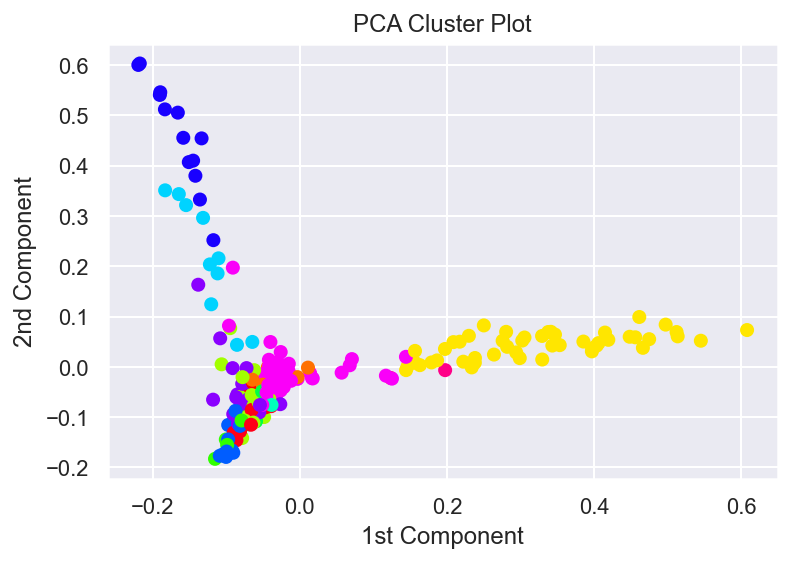

In [47]:
plot_pca(text, cluster_labels)

## Data, Labels
또한 위의 18번째 셀에서 구한 cluster 변수로 각 보도자료가 어느 cluster 에 속하는지를 알 수 있다.

In [52]:
data['Cluster_ID'] = cluster_labels

In [53]:
print("2번 클러스터 보도자료만 출력해보기")
data[data['Cluster_ID']==2]

2번 클러스터 보도자료만 출력해보기


,id,title,contents,date,topics,components,Cluster_ID
14,12-893,$19 Million Stolen Identity Refund Fraud Consp...,"A grand jury sitting in Anchorage, Ala.,...",2012-07-20T00:00:00-04:00,[],[Tax Division],2
18,14-550,$20 Million Stolen Identity Refund Fraud Ring ...,"Tracy Mitchell, Dameisha Mitchell, Latas...",2014-05-22T00:00:00-04:00,[],[Tax Division],2
58,15-1543,Accountant for Michael ‘The Situation’ Sorrent...,The former tax preparer for television persona...,2015-12-16T00:00:00-05:00,[Tax],[Tax Division],2
130,16-505,Alabama and Georgia Residents Sentenced to Pri...,"Two men who conspired to file more than 1,200 ...",2016-04-28T00:00:00-04:00,[Tax],[Tax Division],2
131,15-275,Alabama and Georgia Residents Sentenced to Pri...,"Charnesha Alexander, a Phenix City, Alabama, r...",2015-03-06T00:00:00-05:00,"[Identity Theft, Tax]",[Tax Division],2
...,...,...,...,...,...,...,...
13048,None,Woman Indicted and Arrested for Defrauding the...,Defendant Faces a Forfeiture Allegation of $22...,2015-06-10T00:00:00-04:00,[],[USAO - Puerto Rico],2
13062,14-1406,Wyoming Businessman Sentenced for Obstructing ...,"On Dec. 15, 2014, a Casper, Wyoming, man was s...",2014-12-16T00:00:00-05:00,[],[Tax Division],2
13063,14-482,Wyoming Businessman Sentenced to Prison for Us...,Robert C. Sathre was sentenced today to ...,2014-05-07T00:00:00-04:00,[],[Tax Division],2
13064,13-678,Wyoming Couple Indicted for Tax Evasion,"In an indictment unsealed on June 12, 2013, ...",2013-06-13T00:00:00-04:00,[],[Tax Division],2


**★ components(발행 부서) 들만 보았을때 Tax Division 만 있는 것으로 보아 클러스터링이 잘 되었음을 확인 할 수 있다.★**